#### Density of LEO objects versus height

Make two plots:  

Plot-1 is a 2D dot-plot, with different colours representing the categories. X-axis is the actual height of individual objects. (Average of apogee and perigee typically). Y-axis is a random number between 0 and 1. Could think of this as representing azimuth, randomly chosen, but the real point is simply to stretch into 2D for visualisation reasons. Crowded regions stand out very clearly as vertical stripes, and we can see the regions where categories overlap. However, the density of dots on the screen/paper does not represent volume density.


Plo-2 is a binned density histogram vs height, with the number per bin scaled so that we get correct number per unit volume. Do this with all objects together, not in categories, except for Cosmos 1408 simulation objects. 

Read in data files split into categories:  
Categories:  
1=active, including starlink    
2=debris, including PRC and Ir    
3=leftover (derelict PL and Parts)  
4=C1408 simulated debris  


Based on data provided by Jonathan McDowell  
extracted from General Catalog of Artificial Space Objects  
and simulated debris from C1408 ASAT test, sent by Hugh Lewis, trimmed by me  


First, setup:

In [17]:
from math import *
import random as rand
import numpy as np
from matplotlib import pyplot as plt

# pick a plotting option
# default is inline; for Binder version may need to comment out all of them
# to get the full effect of the 2D plot strongly recommend
# plotting with qt or osx and stretching horizontally to taste
% matplotlib inline 
#% matplotlib osx
#% matplotlib qt
#% matplotlib --list
plt.rcParams['figure.dpi'] = 150   # set scaling of figures

RE=6378.  # mean radius of Earth
hmin=0.0      # min height for plots
hmax=1750.0   # max height for plots
#plt.rcParams['text.usetex'] = True  # enable proper TeX in labels

Now read in datasets, merge into groups as desired, and create random y-axis arrays

In [18]:
#### active satellites
fname="jmd-ac.txt" # non-starlink, includes ACN and ACM
agee=np.loadtxt(fname, usecols=(2))
pgee=np.loadtxt(fname, usecols=(3))
htac=(agee+pgee)/2.

fname="jmd-star.txt"  # Starlink
agee=np.loadtxt(fname, usecols=(2))
pgee=np.loadtxt(fname, usecols=(3))
htstar=(agee+pgee)/2.
    
htact=np.concatenate([htac,htstar])
yact=np.zeros(len(htact))
for  i in range(0,len(htact)):
    yact[i]=rand.random()


#### Debris

fname="jmd-deb.txt"  # debris other than debPRC and DebIr
agee=np.loadtxt(fname, usecols=(2))
pgee=np.loadtxt(fname, usecols=(3))
htdeb=(agee+pgee)/2.

fname="jmd-debir.txt"
agee=np.loadtxt(fname, usecols=(2))
pgee=np.loadtxt(fname, usecols=(3))
htdebir=(agee+pgee)/2.

fname="jmd-debprc.txt"
agee=np.loadtxt(fname, usecols=(2))
pgee=np.loadtxt(fname, usecols=(3))
htdebprc=(agee+pgee)/2.

htdeball=np.concatenate([htdeb,htdebir,htdebprc])
ydeball=np.zeros(len(htdeball))
for  i in range(0,len(htdeball)):
    ydeball[i]=rand.random()


#### Left overs

fname="jmd-part.txt"   # parts including Part and RB
agee=np.loadtxt(fname, usecols=(2))
pgee=np.loadtxt(fname, usecols=(3))
htpart=(agee+pgee)/2.

fname="jmd-dead.txt"    # derelict payloads including PL and PX
agee=np.loadtxt(fname, usecols=(2))
pgee=np.loadtxt(fname, usecols=(3))
htdead=(agee+pgee)/2.

htleft=np.concatenate([htpart,htdead])
yleft=np.zeros(len(htleft))
for  i in range(0,len(htleft)):
    yleft[i]=rand.random()

    
#### C1408 simulation data
fname="C1408-sim.txt"
SMA=np.loadtxt(fname, usecols=(0))    # ignoring eccentricity...
htc1408=SMA-RE   
yc1408=np.zeros(len(htc1408))
for  i in range(0,len(htc1408)):
    yc1408[i]=rand.random()


Now make the 2D dot-plot. Distinguish with colours, but avoid colour-blindness issues: red-green is the main one, and blue-yellow is the other

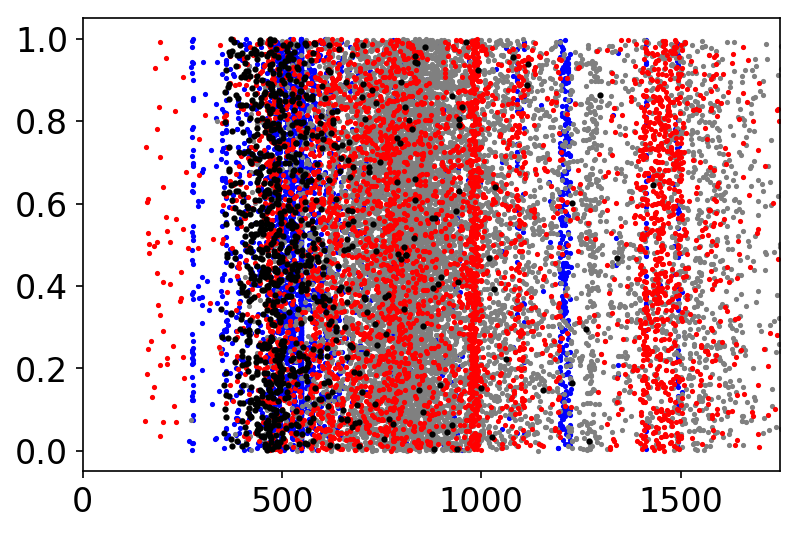

In [19]:
plt.figure()
msize=1.5
plt.xlim([hmin,hmax])
plt.plot(htact,yact,'o',ms=msize,color='blue')  
plt.plot(htdeball,ydeball,'o',ms=msize,color='gray')  
plt.plot(htleft,yleft,'o',ms=msize,color='red') 
plt.plot(htc1408,yc1408,'o',ms=2.0, color='black')
#plt.xlabel('Height above Earth, km',size=16) 
plt.tick_params(labelsize=16)
plt.show()

Now make two histograms - the known objects, concatenated into single list, and the simulated C1408 points. 

Use numpy histogram routine rather than relying on plt.hist, as this makes it easier to manipulate.

Uses same hmin and hmax as dot-plot, but need to choose binsize

In [20]:
htall=np.concatenate([htact,htdeball,htleft])

binsize=10.0

# set an array of the bin edges, 
# starting at left-end of first bin = hmin
# and ending at right-end of last bin = hmax
# note arange has start,stop, step, but doesn't include stop-value
binarray=np.arange(hmin,hmax+binsize,binsize)   

# histogram routine outputs two arrays
# first is values, second is bin edges, including both ends
valsall, edgesall = np.histogram(htall, bins=binarray)
leftall=edgesall[:(len(edgesall) -1)] # left edges only
valsc1408, edgesc1408 = np.histogram(htc1408, bins=binarray)


# get density in each bin
# by dividing by volume of shell
# use radius at centre of bin

vol=np.zeros(len(leftall))
rhoall=np.zeros(len(leftall))
rhoc1408=np.zeros(len(leftall))

for i in range(0,len(vol)):
    radius=RE+leftall[i]+0.5*binsize
    vol[i] = 4.*pi*radius*radius*binsize
    rhoall[i]=valsall[i]/vol[i]
    rhoc1408[i]=valsc1408[i]/vol[i]
#    print(i,leftall[i],vol[i],rho[i])

rhoall=1.e7*rhoall
rhoc1408=1.e7*rhoc1408
rhotot=rhoall+rhoc1408

Now make the density histogram plot, then plot. Use a stacked plot to compared known objects and simulated c1408 objects.

Need to choose rhomax.

Note main problem is that the Starlink density spike is enormous. Hard to show the true height of this without making the rest of the figure too teeny. Just have to let it shoot off the top.



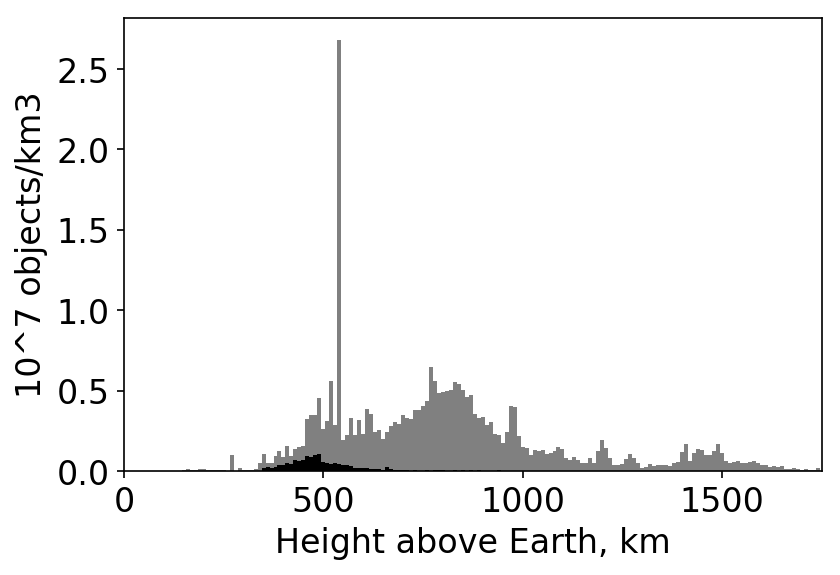

In [21]:
rhomax=3.0e-7


plt.figure()

plt.xlim([0.0,1750.0])
plt.bar(leftall,rhotot,width=binsize,color='gray')
plt.bar(leftall,rhoc1408,width=binsize,color='black')

plt.xlabel('Height above Earth, km',size=16) 
plt.ylabel('10^7 objects/km3',size=16) 
#plt.ylabel('$10^7$ objects km$^{-3}$',size=16) 


plt.tick_params(labelsize=16)

plt.show()